In [1]:
%matplotlib notebook

Niestety po przekopaniu się przez całą dokumentację mne i nieudanych próbach zrobienia czegoś sensownego, stwierdzam, że albo jestem głupia i nie widzę oczywistego rozwiązania, albo nie da się zrobić detekcji sakkad bazująć na mne :(( jest trochę funkcji do detekcji artefaktów i eventów eog, ale wszystko skupia się na znajdywaniu/usuwaniu blinków, a nie sakkad. Jakiś funkcji pozwalających znajdywać określone struktury też nie ma - jedynie dla ERP. Kod poniżej nieskończony, nie wykrywa do końca prawidłowo, ale przyznaję się bez bicia, że był pisany trochę na szybko, żeby było cokolwiek sensownego po tym jak nie dałam sobie rady z mne :((

In [2]:
import mne

In [6]:
import os, re
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_prominences
import numpy as np 
from mne.preprocessing import ICA

In [94]:
def wczytaj(filename):
    eeg = mne.io.read_raw_brainvision(filename,preload = True)
    plt.figure()
    eeg.plot()
    plt.show()
    eeg.info
    print(eeg.info)
    mapa = mne.channels.make_standard_montage('standard_1020')

    
    eeg_mont = eeg.copy().set_montage(mapa)

    chosen_channels = ['Fp1', 'Fp2', 
                    'F7', 'F3', 'Fz', 'F4', 'F8', 
                    'T7', 'C3', 'Cz', 'C4', 'T8', 
                    'P7', 'P3', 'Pz', 'P4', 'P8', 
                    'O1', 'O2'] # (bez elektrod uszynych)




    eeg_20 = eeg_mont.copy()
    eeg_20.pick_channels(chosen_channels)

    eeg_20.set_eeg_reference('average', projection=True)
    eeg_20.filter(1, None, l_trans_bandwidth='auto', filter_length='auto', phase='zero', fir_window='hamming', n_jobs=16)
    eeg_20.filter(None, 49, l_trans_bandwidth='auto', filter_length='auto', phase='zero', fir_window='hamming', n_jobs=16)

    eeg_20.plot(proj=True)
    
    return eeg_20

In [78]:
#for f in os.listdir('.'):
 #   pattern = "sub-ARZ000_task_art_watch"+".*\.vhdr$"
  #  if re.match(pattern, f):
   #     current_signal = wczytaj(f)
        #print("po pierwszej funkcji")
        #detektor_bs(current_signal, 'mne_lib')
        #detektor_bs(current_signal, 'numpy')

In [95]:
#BLINKI
syg1 = current_signal.copy().pick_channels(['Fp1'])
events = mne.preprocessing.find_eog_events(current_signal, event_id=998, l_freq=1, h_freq=10, filter_length='10s', ch_name=['Fp1'], tstart=0, reject_by_annotation=False, thresh=None, verbose=None)
#print (events)
#print(events.shape)

Using EOG channel: Fp1
EOG channel index for this subject is: [0]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 10000 samples (10.000 sec)

Now detecting blinks and generating corresponding events
Found 46 significant peaks
Number of EOG events detected: 46


In [96]:
syg1_m = syg1.get_data().flatten()
print(syg1_m.shape)

(298720,)


In [103]:
Fs = syg1.info['sfreq'] #czestosc probkowania
t = syg1.times # w sek
syg1_m = syg1_m*1000
czas = len(t)/Fs
print(czas, 's')

298.72 s


[3356, 9226, 20508, 27165, 30698, 38584, 44128, 49453, 68909, 78444, 79835, 80045, 82541, 91099, 102731, 107853, 110240, 115878, 119572, 127091, 141409, 147381, 149647, 151599, 152563, 154534, 155403, 162477, 178815, 179753, 192989, 213340, 214472, 224278, 234795, 235458, 237719, 252571, 264725, 267433, 269302, 271488, 280099, 282568, 285026, 295537]


<IPython.core.display.Javascript object>


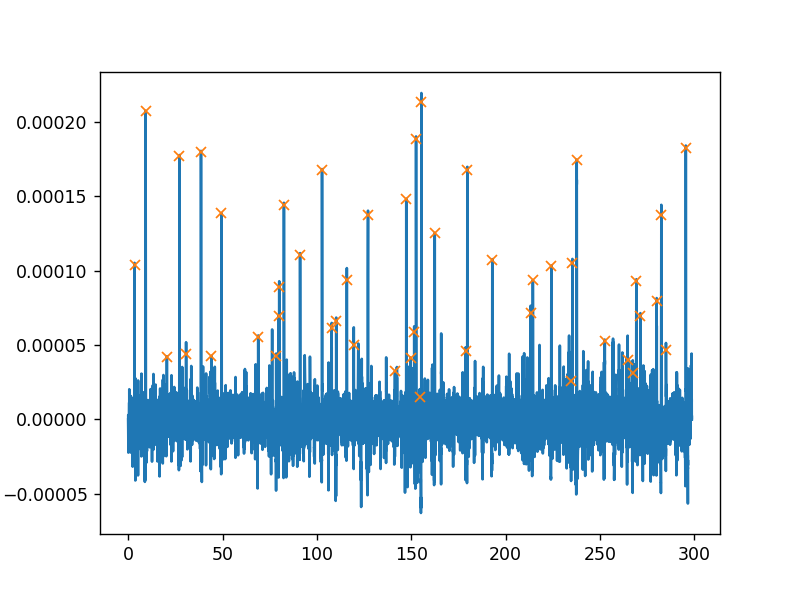

In [98]:
s=[]
for i in range(0,46):
    s.append(events[i,0])
print(s)
plt.figure()
plt.plot(t,syg1_m)
plt.plot(t[s],syg1_m[s],  'x')
plt.show()

In [122]:
def moving_average(signal, n_mean, t, overlap = 1): #sygnał, ilość próbek brana do średniej, ile ma się nakładać przy przesunięciu
    
    mov_av = np.zeros(int(round(len(signal)/(n_mean - overlap))))  
    mov_av[0] = np.mean(signal[:n_mean])
    iterate = 1
    
    for i in range(n_mean- overlap, len(signal) - n_mean, n_mean - overlap):
        mov_av[iterate] = np.mean(signal[i: i + n_mean])
        iterate += 1
    mov_av[-1] = np.mean(signal[i + n_mean:])
    
    min_diff = 0.02
    max_diff = 0.05
    max_amplitude = 0.25
    
    list_idx = []
    for i in range(len(signal) -10):
        if signal[i + 10] - signal[i] > min_diff and signal[i + 10] - signal[i] < max_diff and (i not in s):
            list_idx.append(i)
            
    idx_beg_saccades = np.array(list_idx)[np.where(np.diff(list_idx) > 10)[0]].astype(int)
    idx_beg_saccades = idx_beg_saccades[np.where(np.abs(signal[idx_beg_saccades] - xx[idx_beg_saccades]) < max_amplitude)[0]]
    idx_end_saccades = []
    
    for i in idx_beg_saccades:
        idx_end_saccades.append(i + 100)   

    return mov_av, idx_beg_saccades, idx_end_saccades,

In [123]:
A, start,end = moving_average(syg1_m, int(3*Fs),t, 1)
print(A, start, end)

[-1.27521973e-03  2.61332224e-04 -4.10886278e-03  4.10180024e-03
  6.23812281e-04 -1.21715641e-03  4.97117267e-04 -3.11129947e-04
 -2.80204686e-03  3.59982506e-03 -1.00600058e-03  8.64293087e-04
  1.14372548e-03 -1.45886045e-03 -4.73944879e-04  7.28115065e-04
 -4.92015918e-04  5.44417230e-05 -3.52668062e-05  2.91777895e-04
  5.73620208e-04 -1.04248282e-03  3.46616601e-04  2.44360505e-04
 -7.05104474e-04  2.91456192e-05  6.32761198e-04 -1.92760408e-03
  1.62010377e-03  3.70350986e-04  3.41396524e-04 -1.73024982e-03
  7.87432877e-04  6.49143375e-04 -5.37390811e-04  2.47073731e-03
 -2.23458223e-03 -1.78276213e-04  1.36437793e-04 -1.82397325e-04
  1.58340153e-03 -7.14397801e-04 -5.47883253e-04 -3.09447610e-04
  3.44906250e-04 -2.91870914e-04 -4.89410267e-04  4.32418954e-04
 -1.64702417e-03  2.09380080e-03  1.75684829e-03 -1.77527737e-04
 -1.21529884e-03  6.61568053e-04 -1.20928675e-03  3.63585574e-04
 -1.74032992e-04  2.07650539e-04 -9.91663082e-04  3.50088661e-03
 -2.67490747e-03  2.60473

<IPython.core.display.Javascript object>


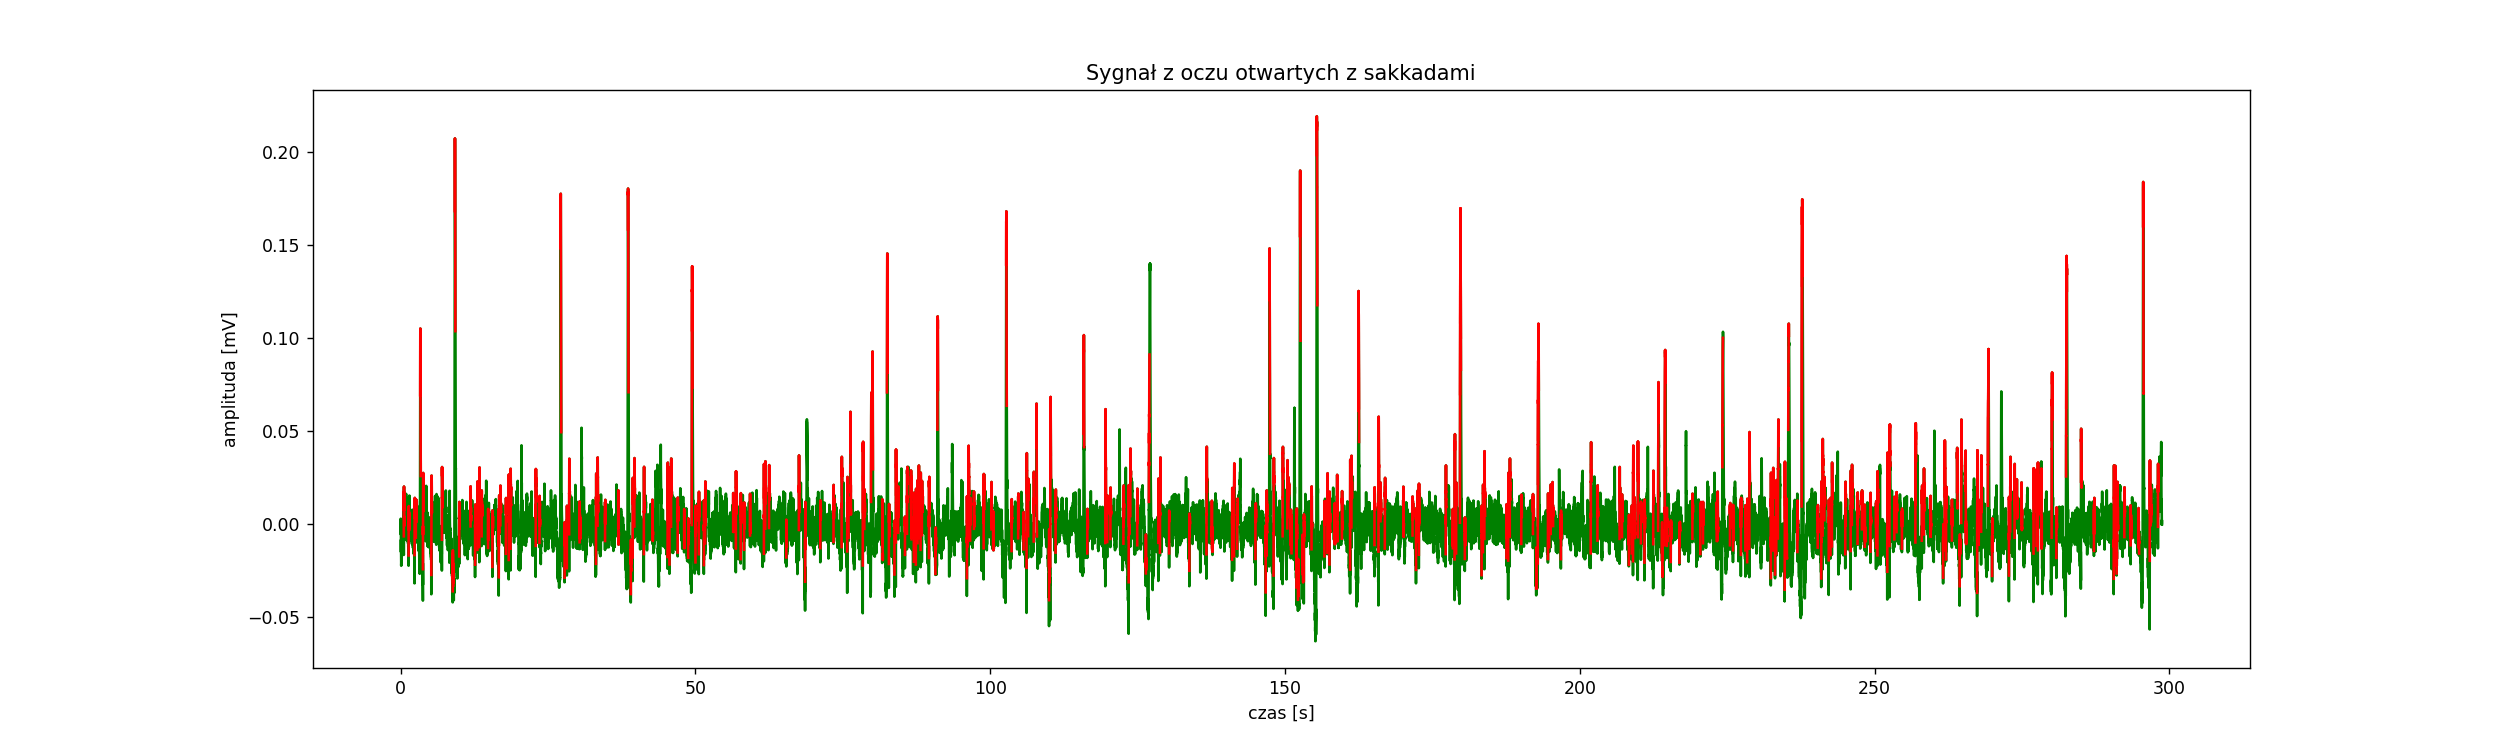

[   554   1364   2376   2592   3325   3793   5216   7011   8846   9195
   9943  11868  12637  13026  13047  13355  13743  14842  15571  16650
  16927  17861  18343  18362  18648  22922  22941  23556  27143  27816
  28200  28591  30362  33136  33406  34679  36916  38561  39044  39366
  39644  41255  42705  45285  45601  45874  46993  48093  48783  49372
  49419  50013  50581  51438  51655  56407  56863  56882  57686  58251
  59271  61619  61641  61849  62488  65419  67552  68608  71186  73424
  74796  75750  75963  76288  78388  78403  78651  79788  80004  81687
  82492  82814  83756  83997  84014  84388  85539  85884  86563  87048
  87391  87670  87877  88194  88413  89608  89627  90704  91045  96046
  96064  96311  96329  96593  97239  98886  98905 100215 100498 102706
 103621 104745 105659 106168 106436 107378 107833 109983 110000 110178
 110200 111084 115837 116468 119523 119539 119840 120384 122591 123485
 123503 123763 124928 126399 126910 128516 128786 130343 133773 136679
 13758

In [124]:
fig = py.figure(figsize=(20,6))
py.plot(t, syg1_m, 'g')
py.xlabel('czas [s]')
py.ylabel('amplituda [mV]')
py.title('Sygnał z oczu otwartych z sakkadami')

for i in range(len(begs)):
    py.plot(t[begs[i]:ends[i]], syg1_m[begs[i]:ends[i]], color = 'red')
py.show()
print(begs)
print(ends)
print(len(begs), len(ends))